# Basic GAN 실습

- [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
- [NIPS 2016 Tutorial:
Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf)
- [image source](https://xiaohongliu.ca/post/gan/)

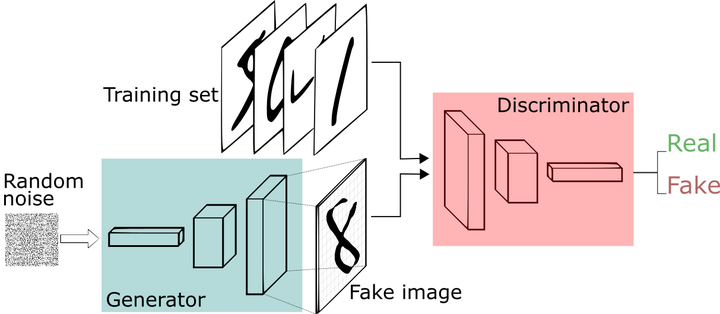

## Library

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader

## Hyperparameters

In [3]:
"""
학습에 사용될 hyperparameter 값들을 넣을 class를 정의합니다.
"""
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [4]:
"""
GAN model 학습에 사용되는 결과 이미지 저장 경로, 에포크 수, 모델 입력 이미지 크기 등을 정의합니다.
"""
config = AttrDict()
config.data_path = 'data/'
config.save_path = 'save/'
config.dataset = 'CIFAR10' #CIFAR10
config.n_epoch = 500
config.log_interval = 100 # 훈련의 로스를 100epoch 마다 확인
config.save_interval = 20 # 모델의 훈련결과 이미지를 20 epoch마다 확인
config.batch_size = 64 # 한번에 몇 장의 이미지를 모델이 볼것인가.
config.learning_rate = 0.0002 #2e-4
config.b1 = 0.5  
config.b2 = 0.999
config.img_shape = (3, 32, 32) # c(컬러이미지 RGB), w, h
config.latent_size = 100
"""
모델 입력 이미지에 수행할 normalization과 모델 생성 결과 이미지에 수행할 denormalization을 정의합니다.
"""
config.augmentation = transforms.Compose([
                        transforms.Resize((config.img_shape[1], config.img_shape[2])),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5]) 
                      ])
config.denormalize = lambda x: x*0.5+0.5
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
if not os.path.isdir(config.data_path):
    os.makedirs(config.data_path)
if not os.path.isdir(os.path.join(config.save_path, config.dataset)):
    os.makedirs(os.path.join(config.save_path, config.dataset))

In [6]:
config.device

device(type='cpu')

## Data load

In [9]:
"""
MNIST와 CIFAR-10은 torchvision 라이브러리에서 제공하여 아래와 같이 사용할 수 있습니다.
"""
if config.dataset == 'MNIST':
    train_dataset = datasets.MNIST(config.data_path,
                                    train=True,
                                    download=True,
                                    transform=config.augmentation
                                  ) 
elif config.dataset == 'CIFAR10': 
    train_dataset = datasets.CIFAR10(config.data_path,
                                       train=True,
                                       download=True,
                                       transform=config.augmentation
                                     )
"""
training set을 Dataloader에 넣습니다. 
"""
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
print(train_dataset)

0it [00:00, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


## GAN model

In [10]:
"""
 일반적으로, GAN에서는 loss가 Discriminator에서부터 Generator로 흐를 때 생길 수 있는 
 vanishing gradient 현상을 완화하기 위해 Leaky ReLU를 많이 사용합니다. 
"""
class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            *self.block(config.latent_size, 128, batchnorm=False), # 잠재백터는 100에서 시작
            *self.block(128, 256),
            *self.block(256, 512),
            *self.block(512, 1024),
            nn.Linear(1024, int(np.prod(config.img_shape))), # 원본이미지 사이즈로 변환
            nn.Tanh() # -1 ~ 1사이로 변환
        )

    def forward(self, z):
        img = self.model(z)
        img = img.reshape(img.shape[0], *config.img_shape)
        return img
    
    def block(self, input_size, output_size, batchnorm=True):
        layers = [nn.Linear(input_size, output_size)]
        if batchnorm:
            layers.append(nn.BatchNorm1d(output_size))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

In [11]:
class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(config.img_shape)), 512), # 이미지를 받아서 일자로 펴준후, 512차원으로 내보냄
            nn.LeakyReLU(0.2, inplace=True), # 배니싱 그레디언트 완화가능
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.reshape(img.shape[0], -1) # 배치차원은 나두고, 나머지를 쭉 핀다.(img.shape[0] 부분)
        validity = self.model(img)
        return validity

#### Binary Cross Entropy loss between the target and the input probabilities

- [torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

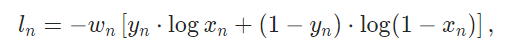

In [12]:
"""
binary cross entropy loss를 사용하여 adversarial loss를 구현합니다.
"""
criterion = nn.BCELoss()

"""
Generator와 Discriminator를 각각 정의하고, 상응하는 optimizer도 함께 정의합니다.
"""
generator = Generator(config).to(config.device)
discriminator = Discriminator(config).to(config.device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))

In [13]:
generator.model

Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Linear(in_features=256, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Linear(in_features=512, out_features=1024, bias=True)
  (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Linear(in_features=1024, out_features=3072, bias=True)
  (12): Tanh()
)

In [14]:
discriminator.model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2, inplace=True)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Training

In [15]:
"""
Generator와 Discriminator를 번갈아 학습합니다.
"""
g_loss_list = []
d_loss_list = []
for epoch in tqdm(range(config.n_epoch)):
    for i, (real_img, _) in enumerate(train_loader):
        
        real_img = real_img.to(config.device)

        """
        adversarial loss에 사용될 ground truth들입니다.
        Discriminator에게 있어 실제 이미지는 1, generator가 생성한 fake 이미지는 0을 label로 합니다.
        반대로 Generator는 자신이 생성한 fake 이미지의 label이 1이 되게 하여 Discriminator를 fooling 합니다.
        """
        valid_label = torch.ones((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        fake_label = torch.zeros((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        
        # ====================================================#
        #                Train Discriminator                  #
        # ====================================================#

        """
        Gaussian random noise를 Generator에게 입력하여 fake 이미지들을 생성합니다.
        """
        z = torch.randn((real_img.shape[0], config.latent_size), device=config.device, dtype=torch.float32)
        gen_img = generator(z)

        """
        Discriminator가 실제 이미지와 Generator가 생성한 이미지를 잘 구별하는지 loss를 계산합니다.
        이 때, Generator는 현재 계산된 loss로 학습되지 않으므로, 
        detach() 함수를 이용하여 생성 이미지를 computation graph에서 분리한 후 Discriminator의 입력으로 넣어줍니다. 
        """
        real_loss = criterion(discriminator(real_img), valid_label)
        fake_loss = criterion(discriminator(gen_img.detach()), fake_label) # 생성된 가짜 이미지는 판별자가 훈련하지 않도록 그레디언트를 삭제
        d_loss = (real_loss + fake_loss) * 0.5 #real과 fake 로스의 평균이 판별자의 loss가됨
        
        """
        Discriminator를 업데이트합니다.
        """
        optimizer_d.zero_grad() # 옵티마이저 초기화
        d_loss.backward() # 역전파, 역전파 과정에서는 fake이미지를 만드는 제너레이터는 업데이트 되지 않는다. detach함수를 통해서
        optimizer_d.step() # 판별자 업데이트

        # ====================================================#
        #                   Train Generator                   #
        # ====================================================#

        """
        Gaussian random noise를 Generator에게 입력하여 fake 이미지들을 생성합니다.
        """
        z = torch.randn((real_img.shape[0], config.latent_size), device=config.device, dtype=torch.float32)
        gen_img = generator(z)

        """
        Generator가 Discriminator를 속일 수 있는지 loss를 계산합니다.
        """
        g_loss = criterion(discriminator(gen_img), valid_label) # 자신이 만든 이미지는 진짜라고 판별자가 학습할 수 있도록 만듬
        
        """
        Generator를 업데이트합니다.
        """
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if (i+1) % config.log_interval == 0:
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            print('Epoch [{}/{}] Batch [{}/{}] Discriminator loss: {:.4f} Generator loss: {:.4f}'.format(
                epoch+1, config.n_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item()))

    if (epoch+1) % config.save_interval == 0:
        save_path = os.path.join(config.save_path, config.dataset, 'epoch_[{}].png'.format(epoch+1))
        gen_img = config.denormalize(gen_img)
        torchvision.utils.save_image(gen_img.data[:25], save_path, nrow=5, normalize=True)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500] Batch [100/782] Discriminator loss: 0.4672 Generator loss: 2.1120
Epoch [1/500] Batch [200/782] Discriminator loss: 0.5862 Generator loss: 2.2235
Epoch [1/500] Batch [300/782] Discriminator loss: 0.5510 Generator loss: 2.9453
Epoch [1/500] Batch [400/782] Discriminator loss: 0.5305 Generator loss: 2.6510
Epoch [1/500] Batch [500/782] Discriminator loss: 0.5515 Generator loss: 2.1389
Epoch [1/500] Batch [600/782] Discriminator loss: 0.5038 Generator loss: 1.7908
Epoch [1/500] Batch [700/782] Discriminator loss: 0.5831 Generator loss: 1.9125
Epoch [2/500] Batch [100/782] Discriminator loss: 0.5923 Generator loss: 1.6201
Epoch [2/500] Batch [200/782] Discriminator loss: 0.6175 Generator loss: 1.6042
Epoch [2/500] Batch [300/782] Discriminator loss: 0.6133 Generator loss: 1.4777
Epoch [2/500] Batch [400/782] Discriminator loss: 0.5835 Generator loss: 1.7312
Epoch [2/500] Batch [500/782] Discriminator loss: 0.6435 Generator loss: 1.3833
Epoch [2/500] Batch [600/782] Discrimina

Epoch [15/500] Batch [500/782] Discriminator loss: 0.6959 Generator loss: 0.8790
Epoch [15/500] Batch [600/782] Discriminator loss: 0.6636 Generator loss: 0.8550
Epoch [15/500] Batch [700/782] Discriminator loss: 0.6645 Generator loss: 0.7662
Epoch [16/500] Batch [100/782] Discriminator loss: 0.6725 Generator loss: 0.7684
Epoch [16/500] Batch [200/782] Discriminator loss: 0.7129 Generator loss: 0.7378
Epoch [16/500] Batch [300/782] Discriminator loss: 0.7025 Generator loss: 0.7615
Epoch [16/500] Batch [400/782] Discriminator loss: 0.6612 Generator loss: 0.8013
Epoch [16/500] Batch [500/782] Discriminator loss: 0.6880 Generator loss: 0.7467
Epoch [16/500] Batch [600/782] Discriminator loss: 0.6851 Generator loss: 0.7956
Epoch [16/500] Batch [700/782] Discriminator loss: 0.6735 Generator loss: 0.7879
Epoch [17/500] Batch [100/782] Discriminator loss: 0.6803 Generator loss: 0.7789
Epoch [17/500] Batch [200/782] Discriminator loss: 0.6920 Generator loss: 0.6982
Epoch [17/500] Batch [300/78

Epoch [30/500] Batch [200/782] Discriminator loss: 0.6854 Generator loss: 0.6952
Epoch [30/500] Batch [300/782] Discriminator loss: 0.6865 Generator loss: 0.7005
Epoch [30/500] Batch [400/782] Discriminator loss: 0.7128 Generator loss: 0.7498
Epoch [30/500] Batch [500/782] Discriminator loss: 0.6891 Generator loss: 0.7474
Epoch [30/500] Batch [600/782] Discriminator loss: 0.7072 Generator loss: 0.6829
Epoch [30/500] Batch [700/782] Discriminator loss: 0.7003 Generator loss: 0.7384
Epoch [31/500] Batch [100/782] Discriminator loss: 0.6804 Generator loss: 0.6960
Epoch [31/500] Batch [200/782] Discriminator loss: 0.6947 Generator loss: 0.7320
Epoch [31/500] Batch [300/782] Discriminator loss: 0.7006 Generator loss: 0.7485
Epoch [31/500] Batch [400/782] Discriminator loss: 0.6859 Generator loss: 0.7809
Epoch [31/500] Batch [500/782] Discriminator loss: 0.6694 Generator loss: 0.7110
Epoch [31/500] Batch [600/782] Discriminator loss: 0.6901 Generator loss: 0.8241
Epoch [31/500] Batch [700/78

Epoch [44/500] Batch [600/782] Discriminator loss: 0.6797 Generator loss: 0.7394
Epoch [44/500] Batch [700/782] Discriminator loss: 0.7056 Generator loss: 0.7364
Epoch [45/500] Batch [100/782] Discriminator loss: 0.6790 Generator loss: 0.7316
Epoch [45/500] Batch [200/782] Discriminator loss: 0.7116 Generator loss: 0.7791
Epoch [45/500] Batch [300/782] Discriminator loss: 0.6990 Generator loss: 0.7618
Epoch [45/500] Batch [400/782] Discriminator loss: 0.6732 Generator loss: 0.7132
Epoch [45/500] Batch [500/782] Discriminator loss: 0.6806 Generator loss: 0.7083
Epoch [45/500] Batch [600/782] Discriminator loss: 0.7131 Generator loss: 0.7165
Epoch [45/500] Batch [700/782] Discriminator loss: 0.7120 Generator loss: 0.6920
Epoch [46/500] Batch [100/782] Discriminator loss: 0.6793 Generator loss: 0.6929
Epoch [46/500] Batch [200/782] Discriminator loss: 0.6921 Generator loss: 0.7320
Epoch [46/500] Batch [300/782] Discriminator loss: 0.6945 Generator loss: 0.7234
Epoch [46/500] Batch [400/78

Epoch [59/500] Batch [300/782] Discriminator loss: 0.6910 Generator loss: 0.7171
Epoch [59/500] Batch [400/782] Discriminator loss: 0.6709 Generator loss: 0.7332
Epoch [59/500] Batch [500/782] Discriminator loss: 0.6940 Generator loss: 0.6929
Epoch [59/500] Batch [600/782] Discriminator loss: 0.6868 Generator loss: 0.8137
Epoch [59/500] Batch [700/782] Discriminator loss: 0.6684 Generator loss: 0.6884
Epoch [60/500] Batch [100/782] Discriminator loss: 0.6889 Generator loss: 0.8745
Epoch [60/500] Batch [200/782] Discriminator loss: 0.7010 Generator loss: 0.7025
Epoch [60/500] Batch [300/782] Discriminator loss: 0.6815 Generator loss: 0.7325
Epoch [60/500] Batch [400/782] Discriminator loss: 0.6625 Generator loss: 0.7467
Epoch [60/500] Batch [500/782] Discriminator loss: 0.6916 Generator loss: 0.7490
Epoch [60/500] Batch [600/782] Discriminator loss: 0.6796 Generator loss: 0.7393
Epoch [60/500] Batch [700/782] Discriminator loss: 0.6952 Generator loss: 0.6846
Epoch [61/500] Batch [100/78

Epoch [73/500] Batch [700/782] Discriminator loss: 0.6914 Generator loss: 0.7439
Epoch [74/500] Batch [100/782] Discriminator loss: 0.6760 Generator loss: 0.7372
Epoch [74/500] Batch [200/782] Discriminator loss: 0.6926 Generator loss: 0.7453
Epoch [74/500] Batch [300/782] Discriminator loss: 0.7114 Generator loss: 0.7964
Epoch [74/500] Batch [400/782] Discriminator loss: 0.6863 Generator loss: 0.7869
Epoch [74/500] Batch [500/782] Discriminator loss: 0.6847 Generator loss: 0.6976
Epoch [74/500] Batch [600/782] Discriminator loss: 0.6976 Generator loss: 0.6672
Epoch [74/500] Batch [700/782] Discriminator loss: 0.6858 Generator loss: 0.7240
Epoch [75/500] Batch [100/782] Discriminator loss: 0.6917 Generator loss: 0.7162
Epoch [75/500] Batch [200/782] Discriminator loss: 0.6926 Generator loss: 0.7309
Epoch [75/500] Batch [300/782] Discriminator loss: 0.6965 Generator loss: 0.7643
Epoch [75/500] Batch [400/782] Discriminator loss: 0.6974 Generator loss: 0.7560
Epoch [75/500] Batch [500/78

Epoch [88/500] Batch [400/782] Discriminator loss: 0.6797 Generator loss: 0.8411
Epoch [88/500] Batch [500/782] Discriminator loss: 0.6516 Generator loss: 0.8032
Epoch [88/500] Batch [600/782] Discriminator loss: 0.6723 Generator loss: 0.7989
Epoch [88/500] Batch [700/782] Discriminator loss: 0.6619 Generator loss: 0.8298
Epoch [89/500] Batch [100/782] Discriminator loss: 0.6640 Generator loss: 0.8035
Epoch [89/500] Batch [200/782] Discriminator loss: 0.6430 Generator loss: 0.7904
Epoch [89/500] Batch [300/782] Discriminator loss: 0.6471 Generator loss: 0.8072
Epoch [89/500] Batch [400/782] Discriminator loss: 0.6651 Generator loss: 0.8236
Epoch [89/500] Batch [500/782] Discriminator loss: 0.6912 Generator loss: 0.6849
Epoch [89/500] Batch [600/782] Discriminator loss: 0.6875 Generator loss: 0.7196
Epoch [89/500] Batch [700/782] Discriminator loss: 0.7042 Generator loss: 0.8799
Epoch [90/500] Batch [100/782] Discriminator loss: 0.6571 Generator loss: 0.8769
Epoch [90/500] Batch [200/78

Epoch [102/500] Batch [700/782] Discriminator loss: 0.6090 Generator loss: 1.0299
Epoch [103/500] Batch [100/782] Discriminator loss: 0.6142 Generator loss: 1.5311
Epoch [103/500] Batch [200/782] Discriminator loss: 0.4841 Generator loss: 1.5300
Epoch [103/500] Batch [300/782] Discriminator loss: 0.4914 Generator loss: 1.2884
Epoch [103/500] Batch [400/782] Discriminator loss: 0.5573 Generator loss: 1.4431
Epoch [103/500] Batch [500/782] Discriminator loss: 0.4832 Generator loss: 0.9363
Epoch [103/500] Batch [600/782] Discriminator loss: 0.5662 Generator loss: 1.1655
Epoch [103/500] Batch [700/782] Discriminator loss: 0.5861 Generator loss: 1.2985
Epoch [104/500] Batch [100/782] Discriminator loss: 0.8208 Generator loss: 1.8213
Epoch [104/500] Batch [200/782] Discriminator loss: 0.6095 Generator loss: 1.3476
Epoch [104/500] Batch [300/782] Discriminator loss: 0.5615 Generator loss: 1.1722
Epoch [104/500] Batch [400/782] Discriminator loss: 0.5327 Generator loss: 1.3089
Epoch [104/500] 

Epoch [117/500] Batch [200/782] Discriminator loss: 0.5635 Generator loss: 1.9649
Epoch [117/500] Batch [300/782] Discriminator loss: 0.4808 Generator loss: 1.5532
Epoch [117/500] Batch [400/782] Discriminator loss: 0.4866 Generator loss: 1.4834
Epoch [117/500] Batch [500/782] Discriminator loss: 0.4989 Generator loss: 1.4318
Epoch [117/500] Batch [600/782] Discriminator loss: 0.5192 Generator loss: 1.4498
Epoch [117/500] Batch [700/782] Discriminator loss: 0.5486 Generator loss: 1.7204
Epoch [118/500] Batch [100/782] Discriminator loss: 0.4383 Generator loss: 1.5231
Epoch [118/500] Batch [200/782] Discriminator loss: 0.4483 Generator loss: 1.7380
Epoch [118/500] Batch [300/782] Discriminator loss: 0.4925 Generator loss: 1.4620
Epoch [118/500] Batch [400/782] Discriminator loss: 0.4465 Generator loss: 1.5640
Epoch [118/500] Batch [500/782] Discriminator loss: 0.4568 Generator loss: 2.0920
Epoch [118/500] Batch [600/782] Discriminator loss: 0.4685 Generator loss: 1.7093
Epoch [118/500] 

Epoch [131/500] Batch [400/782] Discriminator loss: 0.3588 Generator loss: 1.8413
Epoch [131/500] Batch [500/782] Discriminator loss: 0.3266 Generator loss: 1.6284
Epoch [131/500] Batch [600/782] Discriminator loss: 0.4914 Generator loss: 1.5571
Epoch [131/500] Batch [700/782] Discriminator loss: 0.3983 Generator loss: 1.6106
Epoch [132/500] Batch [100/782] Discriminator loss: 0.3875 Generator loss: 1.6194
Epoch [132/500] Batch [200/782] Discriminator loss: 0.3424 Generator loss: 1.8525
Epoch [132/500] Batch [300/782] Discriminator loss: 0.3834 Generator loss: 1.7467
Epoch [132/500] Batch [400/782] Discriminator loss: 0.4655 Generator loss: 1.8480
Epoch [132/500] Batch [500/782] Discriminator loss: 0.5102 Generator loss: 1.8377
Epoch [132/500] Batch [600/782] Discriminator loss: 0.4899 Generator loss: 1.9190
Epoch [132/500] Batch [700/782] Discriminator loss: 0.5284 Generator loss: 1.5375
Epoch [133/500] Batch [100/782] Discriminator loss: 0.4529 Generator loss: 1.5532
Epoch [133/500] 

Epoch [145/500] Batch [600/782] Discriminator loss: 0.4615 Generator loss: 1.6150
Epoch [145/500] Batch [700/782] Discriminator loss: 0.4403 Generator loss: 1.7577
Epoch [146/500] Batch [100/782] Discriminator loss: 0.3860 Generator loss: 1.9660
Epoch [146/500] Batch [200/782] Discriminator loss: 0.6172 Generator loss: 1.9053
Epoch [146/500] Batch [300/782] Discriminator loss: 0.3767 Generator loss: 1.4417
Epoch [146/500] Batch [400/782] Discriminator loss: 0.4560 Generator loss: 1.5364
Epoch [146/500] Batch [500/782] Discriminator loss: 0.3687 Generator loss: 2.0814
Epoch [146/500] Batch [600/782] Discriminator loss: 0.4805 Generator loss: 1.6873
Epoch [146/500] Batch [700/782] Discriminator loss: 0.3631 Generator loss: 1.8897
Epoch [147/500] Batch [100/782] Discriminator loss: 0.3421 Generator loss: 1.8835
Epoch [147/500] Batch [200/782] Discriminator loss: 0.3747 Generator loss: 1.7990
Epoch [147/500] Batch [300/782] Discriminator loss: 0.4102 Generator loss: 1.9159
Epoch [147/500] 

Epoch [160/500] Batch [100/782] Discriminator loss: 0.4014 Generator loss: 2.2615
Epoch [160/500] Batch [200/782] Discriminator loss: 0.4091 Generator loss: 1.8957
Epoch [160/500] Batch [300/782] Discriminator loss: 0.3691 Generator loss: 1.8358
Epoch [160/500] Batch [400/782] Discriminator loss: 0.4593 Generator loss: 1.7581
Epoch [160/500] Batch [500/782] Discriminator loss: 0.3931 Generator loss: 2.0496
Epoch [160/500] Batch [600/782] Discriminator loss: 0.3544 Generator loss: 1.7849
Epoch [160/500] Batch [700/782] Discriminator loss: 0.4696 Generator loss: 1.5306
Epoch [161/500] Batch [100/782] Discriminator loss: 0.3477 Generator loss: 2.0682
Epoch [161/500] Batch [200/782] Discriminator loss: 0.5137 Generator loss: 2.0828
Epoch [161/500] Batch [300/782] Discriminator loss: 0.6012 Generator loss: 1.7947
Epoch [161/500] Batch [400/782] Discriminator loss: 0.4359 Generator loss: 1.8216
Epoch [161/500] Batch [500/782] Discriminator loss: 0.5026 Generator loss: 1.8621
Epoch [161/500] 

Epoch [174/500] Batch [300/782] Discriminator loss: 0.4816 Generator loss: 2.0812
Epoch [174/500] Batch [400/782] Discriminator loss: 0.3320 Generator loss: 1.4728
Epoch [174/500] Batch [500/782] Discriminator loss: 0.4321 Generator loss: 1.7780
Epoch [174/500] Batch [600/782] Discriminator loss: 0.5070 Generator loss: 2.1598
Epoch [174/500] Batch [700/782] Discriminator loss: 0.3729 Generator loss: 1.8105
Epoch [175/500] Batch [100/782] Discriminator loss: 0.4310 Generator loss: 1.9366
Epoch [175/500] Batch [200/782] Discriminator loss: 0.4598 Generator loss: 1.9768
Epoch [175/500] Batch [300/782] Discriminator loss: 0.3346 Generator loss: 1.8216
Epoch [175/500] Batch [400/782] Discriminator loss: 0.5459 Generator loss: 1.5967
Epoch [175/500] Batch [500/782] Discriminator loss: 0.3570 Generator loss: 2.1586
Epoch [175/500] Batch [600/782] Discriminator loss: 0.4215 Generator loss: 1.9855
Epoch [175/500] Batch [700/782] Discriminator loss: 0.4445 Generator loss: 1.7793
Epoch [176/500] 

Epoch [188/500] Batch [500/782] Discriminator loss: 0.4498 Generator loss: 1.7161
Epoch [188/500] Batch [600/782] Discriminator loss: 0.3542 Generator loss: 2.0866
Epoch [188/500] Batch [700/782] Discriminator loss: 0.4709 Generator loss: 2.1555
Epoch [189/500] Batch [100/782] Discriminator loss: 0.3767 Generator loss: 2.1541
Epoch [189/500] Batch [200/782] Discriminator loss: 0.4087 Generator loss: 2.0055
Epoch [189/500] Batch [300/782] Discriminator loss: 0.4347 Generator loss: 2.4496
Epoch [189/500] Batch [400/782] Discriminator loss: 0.3421 Generator loss: 2.0677
Epoch [189/500] Batch [500/782] Discriminator loss: 0.3425 Generator loss: 1.8335
Epoch [189/500] Batch [600/782] Discriminator loss: 0.5013 Generator loss: 2.2733
Epoch [189/500] Batch [700/782] Discriminator loss: 0.3414 Generator loss: 1.8273
Epoch [190/500] Batch [100/782] Discriminator loss: 0.4392 Generator loss: 1.9832
Epoch [190/500] Batch [200/782] Discriminator loss: 0.4138 Generator loss: 2.0046
Epoch [190/500] 

Epoch [202/500] Batch [700/782] Discriminator loss: 0.4844 Generator loss: 1.7993
Epoch [203/500] Batch [100/782] Discriminator loss: 0.5317 Generator loss: 2.0437
Epoch [203/500] Batch [200/782] Discriminator loss: 0.3731 Generator loss: 2.0444
Epoch [203/500] Batch [300/782] Discriminator loss: 0.2821 Generator loss: 1.8370
Epoch [203/500] Batch [400/782] Discriminator loss: 0.3540 Generator loss: 1.8427
Epoch [203/500] Batch [500/782] Discriminator loss: 0.4209 Generator loss: 1.8245
Epoch [203/500] Batch [600/782] Discriminator loss: 0.3759 Generator loss: 2.4511
Epoch [203/500] Batch [700/782] Discriminator loss: 0.4920 Generator loss: 2.0489
Epoch [204/500] Batch [100/782] Discriminator loss: 0.3987 Generator loss: 2.1190
Epoch [204/500] Batch [200/782] Discriminator loss: 0.3144 Generator loss: 2.1786
Epoch [204/500] Batch [300/782] Discriminator loss: 0.4778 Generator loss: 1.7396
Epoch [204/500] Batch [400/782] Discriminator loss: 0.5377 Generator loss: 2.2477
Epoch [204/500] 

Epoch [217/500] Batch [200/782] Discriminator loss: 0.3871 Generator loss: 2.1303
Epoch [217/500] Batch [300/782] Discriminator loss: 0.4252 Generator loss: 1.8896
Epoch [217/500] Batch [400/782] Discriminator loss: 0.2697 Generator loss: 2.1048
Epoch [217/500] Batch [500/782] Discriminator loss: 0.3167 Generator loss: 2.4542
Epoch [217/500] Batch [600/782] Discriminator loss: 0.2419 Generator loss: 1.8773
Epoch [217/500] Batch [700/782] Discriminator loss: 0.4257 Generator loss: 2.1793
Epoch [218/500] Batch [100/782] Discriminator loss: 0.3334 Generator loss: 2.3633
Epoch [218/500] Batch [200/782] Discriminator loss: 0.3667 Generator loss: 2.2247
Epoch [218/500] Batch [300/782] Discriminator loss: 0.4258 Generator loss: 1.6405
Epoch [218/500] Batch [400/782] Discriminator loss: 0.4592 Generator loss: 1.9810
Epoch [218/500] Batch [500/782] Discriminator loss: 0.4678 Generator loss: 1.7165
Epoch [218/500] Batch [600/782] Discriminator loss: 0.4763 Generator loss: 1.9438
Epoch [218/500] 

Epoch [231/500] Batch [400/782] Discriminator loss: 0.4952 Generator loss: 2.3363
Epoch [231/500] Batch [500/782] Discriminator loss: 0.3306 Generator loss: 1.9363
Epoch [231/500] Batch [600/782] Discriminator loss: 0.4575 Generator loss: 1.8064
Epoch [231/500] Batch [700/782] Discriminator loss: 0.2914 Generator loss: 2.1315
Epoch [232/500] Batch [100/782] Discriminator loss: 0.2841 Generator loss: 2.2448
Epoch [232/500] Batch [200/782] Discriminator loss: 0.3184 Generator loss: 2.4266
Epoch [232/500] Batch [300/782] Discriminator loss: 0.3523 Generator loss: 2.0291
Epoch [232/500] Batch [400/782] Discriminator loss: 0.3340 Generator loss: 1.9912
Epoch [232/500] Batch [500/782] Discriminator loss: 0.3358 Generator loss: 1.9808
Epoch [232/500] Batch [600/782] Discriminator loss: 0.3519 Generator loss: 2.0019
Epoch [232/500] Batch [700/782] Discriminator loss: 0.2668 Generator loss: 2.7358
Epoch [233/500] Batch [100/782] Discriminator loss: 0.2739 Generator loss: 2.8807
Epoch [233/500] 

Epoch [245/500] Batch [600/782] Discriminator loss: 0.3821 Generator loss: 1.7076
Epoch [245/500] Batch [700/782] Discriminator loss: 0.2523 Generator loss: 2.4562
Epoch [246/500] Batch [100/782] Discriminator loss: 0.3115 Generator loss: 2.5419
Epoch [246/500] Batch [200/782] Discriminator loss: 0.4489 Generator loss: 2.3293
Epoch [246/500] Batch [300/782] Discriminator loss: 0.3954 Generator loss: 1.8826
Epoch [246/500] Batch [400/782] Discriminator loss: 0.3979 Generator loss: 2.4754
Epoch [246/500] Batch [500/782] Discriminator loss: 0.4462 Generator loss: 2.3103
Epoch [246/500] Batch [600/782] Discriminator loss: 0.3285 Generator loss: 1.8586
Epoch [246/500] Batch [700/782] Discriminator loss: 0.4045 Generator loss: 1.9594
Epoch [247/500] Batch [100/782] Discriminator loss: 0.3768 Generator loss: 1.9859
Epoch [247/500] Batch [200/782] Discriminator loss: 0.3683 Generator loss: 2.5974
Epoch [247/500] Batch [300/782] Discriminator loss: 0.3959 Generator loss: 2.2693
Epoch [247/500] 

Epoch [260/500] Batch [100/782] Discriminator loss: 0.3038 Generator loss: 2.5661
Epoch [260/500] Batch [200/782] Discriminator loss: 0.3303 Generator loss: 1.6159
Epoch [260/500] Batch [300/782] Discriminator loss: 0.4063 Generator loss: 2.3597
Epoch [260/500] Batch [400/782] Discriminator loss: 0.4288 Generator loss: 2.3966
Epoch [260/500] Batch [500/782] Discriminator loss: 0.4176 Generator loss: 2.1760
Epoch [260/500] Batch [600/782] Discriminator loss: 0.3694 Generator loss: 2.3721
Epoch [260/500] Batch [700/782] Discriminator loss: 0.2335 Generator loss: 2.3569
Epoch [261/500] Batch [100/782] Discriminator loss: 0.3285 Generator loss: 2.2979
Epoch [261/500] Batch [200/782] Discriminator loss: 0.4127 Generator loss: 2.0589
Epoch [261/500] Batch [300/782] Discriminator loss: 0.5340 Generator loss: 2.1765
Epoch [261/500] Batch [400/782] Discriminator loss: 0.3669 Generator loss: 2.1561
Epoch [261/500] Batch [500/782] Discriminator loss: 0.3812 Generator loss: 2.4559
Epoch [261/500] 

Epoch [274/500] Batch [300/782] Discriminator loss: 0.3586 Generator loss: 2.4405
Epoch [274/500] Batch [400/782] Discriminator loss: 0.3931 Generator loss: 2.3122
Epoch [274/500] Batch [500/782] Discriminator loss: 0.4254 Generator loss: 2.3915
Epoch [274/500] Batch [600/782] Discriminator loss: 0.3654 Generator loss: 1.6016
Epoch [274/500] Batch [700/782] Discriminator loss: 0.3107 Generator loss: 2.0292
Epoch [275/500] Batch [100/782] Discriminator loss: 0.3633 Generator loss: 1.4653
Epoch [275/500] Batch [200/782] Discriminator loss: 0.2825 Generator loss: 2.5402
Epoch [275/500] Batch [300/782] Discriminator loss: 0.4381 Generator loss: 2.4832
Epoch [275/500] Batch [400/782] Discriminator loss: 0.4394 Generator loss: 2.6799
Epoch [275/500] Batch [500/782] Discriminator loss: 0.3199 Generator loss: 2.2103
Epoch [275/500] Batch [600/782] Discriminator loss: 0.5697 Generator loss: 2.0160
Epoch [275/500] Batch [700/782] Discriminator loss: 0.3812 Generator loss: 2.1824
Epoch [276/500] 

Epoch [288/500] Batch [500/782] Discriminator loss: 0.4449 Generator loss: 1.8996
Epoch [288/500] Batch [600/782] Discriminator loss: 0.3832 Generator loss: 2.5447
Epoch [288/500] Batch [700/782] Discriminator loss: 0.4362 Generator loss: 2.2896
Epoch [289/500] Batch [100/782] Discriminator loss: 0.4816 Generator loss: 2.1287
Epoch [289/500] Batch [200/782] Discriminator loss: 0.3932 Generator loss: 2.2004
Epoch [289/500] Batch [300/782] Discriminator loss: 0.4033 Generator loss: 2.2386
Epoch [289/500] Batch [400/782] Discriminator loss: 0.3254 Generator loss: 2.2803
Epoch [289/500] Batch [500/782] Discriminator loss: 0.4368 Generator loss: 2.3025
Epoch [289/500] Batch [600/782] Discriminator loss: 0.3547 Generator loss: 2.8303
Epoch [289/500] Batch [700/782] Discriminator loss: 0.4043 Generator loss: 2.5731
Epoch [290/500] Batch [100/782] Discriminator loss: 0.2748 Generator loss: 2.5839
Epoch [290/500] Batch [200/782] Discriminator loss: 0.3233 Generator loss: 2.3899
Epoch [290/500] 

Epoch [302/500] Batch [700/782] Discriminator loss: 0.3601 Generator loss: 2.8452
Epoch [303/500] Batch [100/782] Discriminator loss: 0.2755 Generator loss: 2.7119
Epoch [303/500] Batch [200/782] Discriminator loss: 0.2466 Generator loss: 2.1047
Epoch [303/500] Batch [300/782] Discriminator loss: 0.3626 Generator loss: 1.9712
Epoch [303/500] Batch [400/782] Discriminator loss: 0.3506 Generator loss: 1.9985
Epoch [303/500] Batch [500/782] Discriminator loss: 0.4034 Generator loss: 2.4816
Epoch [303/500] Batch [600/782] Discriminator loss: 0.2660 Generator loss: 2.1426
Epoch [303/500] Batch [700/782] Discriminator loss: 0.3510 Generator loss: 2.6407
Epoch [304/500] Batch [100/782] Discriminator loss: 0.2901 Generator loss: 2.2033
Epoch [304/500] Batch [200/782] Discriminator loss: 0.3550 Generator loss: 2.1818
Epoch [304/500] Batch [300/782] Discriminator loss: 0.3820 Generator loss: 2.1594
Epoch [304/500] Batch [400/782] Discriminator loss: 0.3889 Generator loss: 2.2902
Epoch [304/500] 

Epoch [317/500] Batch [200/782] Discriminator loss: 0.3960 Generator loss: 2.7628
Epoch [317/500] Batch [300/782] Discriminator loss: 0.3483 Generator loss: 2.5345
Epoch [317/500] Batch [400/782] Discriminator loss: 0.3518 Generator loss: 2.2652
Epoch [317/500] Batch [500/782] Discriminator loss: 0.3994 Generator loss: 2.2667
Epoch [317/500] Batch [600/782] Discriminator loss: 0.2989 Generator loss: 2.1058
Epoch [317/500] Batch [700/782] Discriminator loss: 0.4338 Generator loss: 2.2858
Epoch [318/500] Batch [100/782] Discriminator loss: 0.2745 Generator loss: 2.3276
Epoch [318/500] Batch [200/782] Discriminator loss: 0.3133 Generator loss: 2.1037
Epoch [318/500] Batch [300/782] Discriminator loss: 0.3161 Generator loss: 2.2640
Epoch [318/500] Batch [400/782] Discriminator loss: 0.3590 Generator loss: 2.9710
Epoch [318/500] Batch [500/782] Discriminator loss: 0.3341 Generator loss: 2.2564
Epoch [318/500] Batch [600/782] Discriminator loss: 0.3675 Generator loss: 2.3390
Epoch [318/500] 

Epoch [331/500] Batch [400/782] Discriminator loss: 0.2697 Generator loss: 2.0408
Epoch [331/500] Batch [500/782] Discriminator loss: 0.2414 Generator loss: 2.5397
Epoch [331/500] Batch [600/782] Discriminator loss: 0.3500 Generator loss: 2.9236
Epoch [331/500] Batch [700/782] Discriminator loss: 0.4093 Generator loss: 2.2867
Epoch [332/500] Batch [100/782] Discriminator loss: 0.3134 Generator loss: 2.7748
Epoch [332/500] Batch [200/782] Discriminator loss: 0.3118 Generator loss: 2.0205
Epoch [332/500] Batch [300/782] Discriminator loss: 0.2786 Generator loss: 2.2733
Epoch [332/500] Batch [400/782] Discriminator loss: 0.3543 Generator loss: 2.1775
Epoch [332/500] Batch [500/782] Discriminator loss: 0.3506 Generator loss: 2.3760
Epoch [332/500] Batch [600/782] Discriminator loss: 0.3241 Generator loss: 2.2915
Epoch [332/500] Batch [700/782] Discriminator loss: 0.3404 Generator loss: 2.6319
Epoch [333/500] Batch [100/782] Discriminator loss: 0.3334 Generator loss: 2.3892
Epoch [333/500] 

Epoch [345/500] Batch [600/782] Discriminator loss: 0.2976 Generator loss: 2.6026
Epoch [345/500] Batch [700/782] Discriminator loss: 0.3810 Generator loss: 2.9451
Epoch [346/500] Batch [100/782] Discriminator loss: 0.2595 Generator loss: 2.9130
Epoch [346/500] Batch [200/782] Discriminator loss: 0.3901 Generator loss: 2.2802
Epoch [346/500] Batch [300/782] Discriminator loss: 0.3366 Generator loss: 2.2757
Epoch [346/500] Batch [400/782] Discriminator loss: 0.3337 Generator loss: 2.6657
Epoch [346/500] Batch [500/782] Discriminator loss: 0.2715 Generator loss: 2.5456
Epoch [346/500] Batch [600/782] Discriminator loss: 0.2726 Generator loss: 2.4411
Epoch [346/500] Batch [700/782] Discriminator loss: 0.3071 Generator loss: 2.8537
Epoch [347/500] Batch [100/782] Discriminator loss: 0.3006 Generator loss: 2.1193
Epoch [347/500] Batch [200/782] Discriminator loss: 0.3936 Generator loss: 2.5447
Epoch [347/500] Batch [300/782] Discriminator loss: 0.4203 Generator loss: 2.9413
Epoch [347/500] 

Epoch [360/500] Batch [100/782] Discriminator loss: 0.3701 Generator loss: 2.6296
Epoch [360/500] Batch [200/782] Discriminator loss: 0.3404 Generator loss: 2.2950
Epoch [360/500] Batch [300/782] Discriminator loss: 0.3079 Generator loss: 2.3773
Epoch [360/500] Batch [400/782] Discriminator loss: 0.2969 Generator loss: 2.5356
Epoch [360/500] Batch [500/782] Discriminator loss: 0.3795 Generator loss: 2.5548
Epoch [360/500] Batch [600/782] Discriminator loss: 0.3169 Generator loss: 2.5154
Epoch [360/500] Batch [700/782] Discriminator loss: 0.3140 Generator loss: 2.8786
Epoch [361/500] Batch [100/782] Discriminator loss: 0.6855 Generator loss: 2.7823
Epoch [361/500] Batch [200/782] Discriminator loss: 0.3855 Generator loss: 2.2711
Epoch [361/500] Batch [300/782] Discriminator loss: 0.2927 Generator loss: 2.8050
Epoch [361/500] Batch [400/782] Discriminator loss: 0.3629 Generator loss: 2.8137
Epoch [361/500] Batch [500/782] Discriminator loss: 0.4772 Generator loss: 2.0213
Epoch [361/500] 

Epoch [374/500] Batch [300/782] Discriminator loss: 0.3209 Generator loss: 2.6531
Epoch [374/500] Batch [400/782] Discriminator loss: 0.2987 Generator loss: 2.4846
Epoch [374/500] Batch [500/782] Discriminator loss: 0.3094 Generator loss: 2.5091
Epoch [374/500] Batch [600/782] Discriminator loss: 0.3148 Generator loss: 2.5961
Epoch [374/500] Batch [700/782] Discriminator loss: 0.2806 Generator loss: 2.1476
Epoch [375/500] Batch [100/782] Discriminator loss: 0.3147 Generator loss: 2.6561
Epoch [375/500] Batch [200/782] Discriminator loss: 0.3845 Generator loss: 3.5530
Epoch [375/500] Batch [300/782] Discriminator loss: 0.4063 Generator loss: 2.4019
Epoch [375/500] Batch [400/782] Discriminator loss: 0.3024 Generator loss: 2.5513
Epoch [375/500] Batch [500/782] Discriminator loss: 0.2650 Generator loss: 2.4499
Epoch [375/500] Batch [600/782] Discriminator loss: 0.4479 Generator loss: 2.4834
Epoch [375/500] Batch [700/782] Discriminator loss: 0.3278 Generator loss: 2.3553
Epoch [376/500] 

Epoch [388/500] Batch [500/782] Discriminator loss: 0.3214 Generator loss: 2.2736
Epoch [388/500] Batch [600/782] Discriminator loss: 0.3487 Generator loss: 2.7588
Epoch [388/500] Batch [700/782] Discriminator loss: 0.4049 Generator loss: 3.2680
Epoch [389/500] Batch [100/782] Discriminator loss: 0.2262 Generator loss: 2.3677
Epoch [389/500] Batch [200/782] Discriminator loss: 0.3617 Generator loss: 2.7161
Epoch [389/500] Batch [300/782] Discriminator loss: 0.2846 Generator loss: 2.7740
Epoch [389/500] Batch [400/782] Discriminator loss: 0.2534 Generator loss: 2.3217
Epoch [389/500] Batch [500/782] Discriminator loss: 0.2513 Generator loss: 2.3434
Epoch [389/500] Batch [600/782] Discriminator loss: 0.3554 Generator loss: 2.7806
Epoch [389/500] Batch [700/782] Discriminator loss: 0.3166 Generator loss: 2.1636
Epoch [390/500] Batch [100/782] Discriminator loss: 0.3235 Generator loss: 2.3864
Epoch [390/500] Batch [200/782] Discriminator loss: 0.3587 Generator loss: 2.8796
Epoch [390/500] 

Epoch [402/500] Batch [700/782] Discriminator loss: 0.3759 Generator loss: 2.4912
Epoch [403/500] Batch [100/782] Discriminator loss: 0.5834 Generator loss: 2.2304
Epoch [403/500] Batch [200/782] Discriminator loss: 0.2965 Generator loss: 2.6818
Epoch [403/500] Batch [300/782] Discriminator loss: 0.4746 Generator loss: 3.1891
Epoch [403/500] Batch [400/782] Discriminator loss: 0.3068 Generator loss: 3.0924
Epoch [403/500] Batch [500/782] Discriminator loss: 0.4152 Generator loss: 2.8700
Epoch [403/500] Batch [600/782] Discriminator loss: 0.2533 Generator loss: 2.2268
Epoch [403/500] Batch [700/782] Discriminator loss: 0.3376 Generator loss: 2.5278
Epoch [404/500] Batch [100/782] Discriminator loss: 0.3136 Generator loss: 2.2009
Epoch [404/500] Batch [200/782] Discriminator loss: 0.2940 Generator loss: 2.4824
Epoch [404/500] Batch [300/782] Discriminator loss: 0.3675 Generator loss: 2.3100
Epoch [404/500] Batch [400/782] Discriminator loss: 0.3389 Generator loss: 2.1139
Epoch [404/500] 

Epoch [417/500] Batch [200/782] Discriminator loss: 0.3580 Generator loss: 3.3346
Epoch [417/500] Batch [300/782] Discriminator loss: 0.3274 Generator loss: 2.2980
Epoch [417/500] Batch [400/782] Discriminator loss: 0.2918 Generator loss: 3.1003
Epoch [417/500] Batch [500/782] Discriminator loss: 0.3133 Generator loss: 2.6273
Epoch [417/500] Batch [600/782] Discriminator loss: 0.2546 Generator loss: 2.9489
Epoch [417/500] Batch [700/782] Discriminator loss: 0.3947 Generator loss: 2.7707
Epoch [418/500] Batch [100/782] Discriminator loss: 0.2929 Generator loss: 2.7973
Epoch [418/500] Batch [200/782] Discriminator loss: 0.3819 Generator loss: 2.3399
Epoch [418/500] Batch [300/782] Discriminator loss: 0.4748 Generator loss: 1.9775
Epoch [418/500] Batch [400/782] Discriminator loss: 0.2617 Generator loss: 2.6788
Epoch [418/500] Batch [500/782] Discriminator loss: 0.3804 Generator loss: 2.8840
Epoch [418/500] Batch [600/782] Discriminator loss: 0.2762 Generator loss: 2.1252
Epoch [418/500] 

Epoch [431/500] Batch [400/782] Discriminator loss: 0.3578 Generator loss: 2.4744
Epoch [431/500] Batch [500/782] Discriminator loss: 0.3004 Generator loss: 2.1909
Epoch [431/500] Batch [600/782] Discriminator loss: 0.2632 Generator loss: 2.7521
Epoch [431/500] Batch [700/782] Discriminator loss: 0.2525 Generator loss: 3.5936
Epoch [432/500] Batch [100/782] Discriminator loss: 0.2520 Generator loss: 2.6649
Epoch [432/500] Batch [200/782] Discriminator loss: 0.3290 Generator loss: 2.1539
Epoch [432/500] Batch [300/782] Discriminator loss: 0.3083 Generator loss: 2.7548
Epoch [432/500] Batch [400/782] Discriminator loss: 0.2917 Generator loss: 2.4425
Epoch [432/500] Batch [500/782] Discriminator loss: 0.2902 Generator loss: 2.8753
Epoch [432/500] Batch [600/782] Discriminator loss: 0.3313 Generator loss: 2.8665
Epoch [432/500] Batch [700/782] Discriminator loss: 0.3837 Generator loss: 3.1093
Epoch [433/500] Batch [100/782] Discriminator loss: 0.3235 Generator loss: 2.9571
Epoch [433/500] 

Epoch [445/500] Batch [600/782] Discriminator loss: 0.2264 Generator loss: 2.9303
Epoch [445/500] Batch [700/782] Discriminator loss: 0.2667 Generator loss: 2.6945
Epoch [446/500] Batch [100/782] Discriminator loss: 0.2383 Generator loss: 2.6526
Epoch [446/500] Batch [200/782] Discriminator loss: 0.3175 Generator loss: 2.9089
Epoch [446/500] Batch [300/782] Discriminator loss: 0.3482 Generator loss: 3.0641
Epoch [446/500] Batch [400/782] Discriminator loss: 0.3458 Generator loss: 2.6800
Epoch [446/500] Batch [500/782] Discriminator loss: 0.2163 Generator loss: 2.8823
Epoch [446/500] Batch [600/782] Discriminator loss: 0.3215 Generator loss: 2.7272
Epoch [446/500] Batch [700/782] Discriminator loss: 0.4017 Generator loss: 2.6512
Epoch [447/500] Batch [100/782] Discriminator loss: 0.2558 Generator loss: 2.6101
Epoch [447/500] Batch [200/782] Discriminator loss: 0.3017 Generator loss: 2.9705
Epoch [447/500] Batch [300/782] Discriminator loss: 0.3394 Generator loss: 2.6809
Epoch [447/500] 

Epoch [460/500] Batch [100/782] Discriminator loss: 0.2461 Generator loss: 3.5412
Epoch [460/500] Batch [200/782] Discriminator loss: 0.2617 Generator loss: 2.0485
Epoch [460/500] Batch [300/782] Discriminator loss: 0.2272 Generator loss: 2.4939
Epoch [460/500] Batch [400/782] Discriminator loss: 0.3653 Generator loss: 3.1159
Epoch [460/500] Batch [500/782] Discriminator loss: 0.5228 Generator loss: 2.6588
Epoch [460/500] Batch [600/782] Discriminator loss: 0.3699 Generator loss: 2.2652
Epoch [460/500] Batch [700/782] Discriminator loss: 0.3270 Generator loss: 2.9747
Epoch [461/500] Batch [100/782] Discriminator loss: 0.5006 Generator loss: 2.7444
Epoch [461/500] Batch [200/782] Discriminator loss: 0.3150 Generator loss: 2.6480
Epoch [461/500] Batch [300/782] Discriminator loss: 0.2769 Generator loss: 3.0724
Epoch [461/500] Batch [400/782] Discriminator loss: 0.3524 Generator loss: 2.8821
Epoch [461/500] Batch [500/782] Discriminator loss: 0.2453 Generator loss: 2.7982
Epoch [461/500] 

Epoch [474/500] Batch [300/782] Discriminator loss: 0.3863 Generator loss: 2.6400
Epoch [474/500] Batch [400/782] Discriminator loss: 0.2727 Generator loss: 3.0278
Epoch [474/500] Batch [500/782] Discriminator loss: 0.2492 Generator loss: 2.7779
Epoch [474/500] Batch [600/782] Discriminator loss: 0.3162 Generator loss: 2.6462
Epoch [474/500] Batch [700/782] Discriminator loss: 0.2595 Generator loss: 3.1940
Epoch [475/500] Batch [100/782] Discriminator loss: 0.2884 Generator loss: 2.8836
Epoch [475/500] Batch [200/782] Discriminator loss: 0.3558 Generator loss: 2.5865
Epoch [475/500] Batch [300/782] Discriminator loss: 0.3225 Generator loss: 2.8156
Epoch [475/500] Batch [400/782] Discriminator loss: 0.3205 Generator loss: 2.4598
Epoch [475/500] Batch [500/782] Discriminator loss: 0.5055 Generator loss: 3.1878
Epoch [475/500] Batch [600/782] Discriminator loss: 0.2287 Generator loss: 2.9494
Epoch [475/500] Batch [700/782] Discriminator loss: 0.3070 Generator loss: 3.1410
Epoch [476/500] 

Epoch [488/500] Batch [500/782] Discriminator loss: 0.3057 Generator loss: 2.7061
Epoch [488/500] Batch [600/782] Discriminator loss: 0.3135 Generator loss: 2.7819
Epoch [488/500] Batch [700/782] Discriminator loss: 0.2759 Generator loss: 2.5849
Epoch [489/500] Batch [100/782] Discriminator loss: 0.2860 Generator loss: 2.9822
Epoch [489/500] Batch [200/782] Discriminator loss: 0.2347 Generator loss: 2.3683
Epoch [489/500] Batch [300/782] Discriminator loss: 0.3168 Generator loss: 3.1890
Epoch [489/500] Batch [400/782] Discriminator loss: 0.3189 Generator loss: 3.3091
Epoch [489/500] Batch [500/782] Discriminator loss: 0.2148 Generator loss: 2.5203
Epoch [489/500] Batch [600/782] Discriminator loss: 0.2664 Generator loss: 3.0988
Epoch [489/500] Batch [700/782] Discriminator loss: 0.2306 Generator loss: 2.5778
Epoch [490/500] Batch [100/782] Discriminator loss: 0.2692 Generator loss: 2.9507
Epoch [490/500] Batch [200/782] Discriminator loss: 0.3271 Generator loss: 2.8612
Epoch [490/500] 

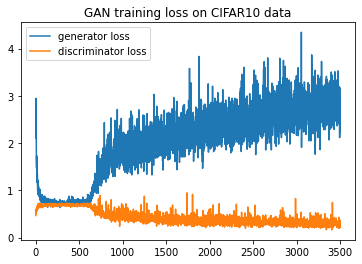

In [16]:
plt.title('GAN training loss on {} data'.format(config.dataset))
plt.plot(g_loss_list, label='generator loss')
plt.plot(d_loss_list, label='discriminator loss')
plt.legend()
plt.show()

## Qualitative results

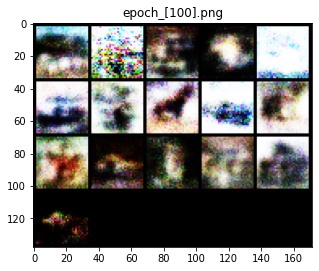

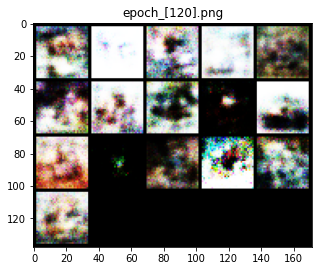

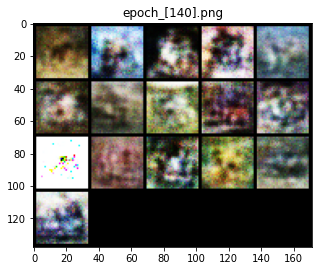

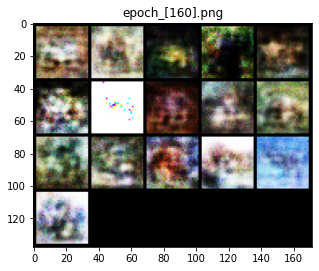

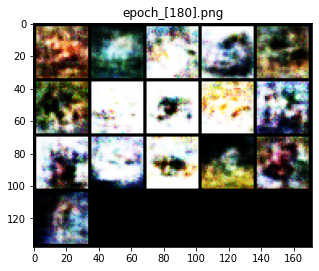

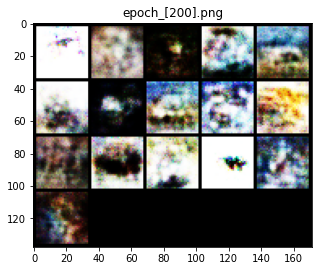

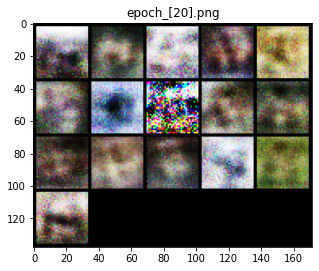

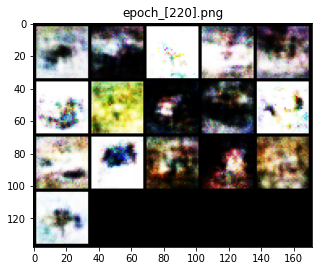

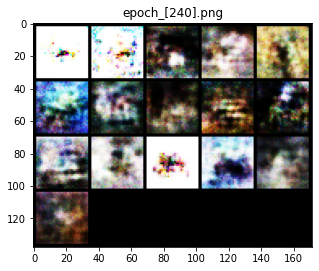

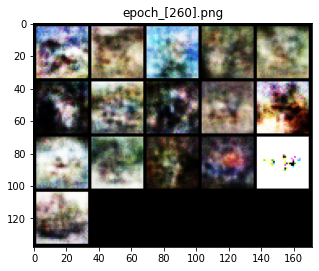

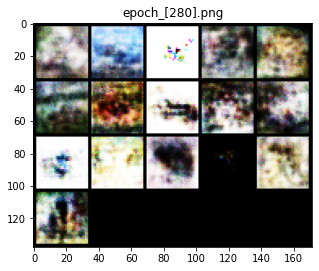

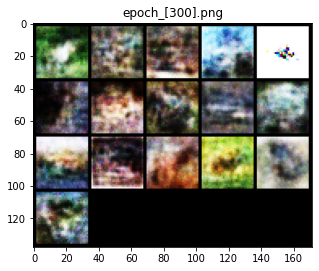

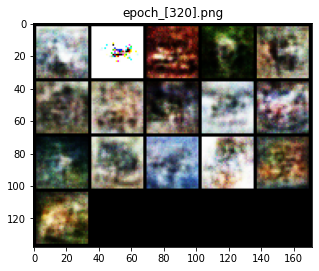

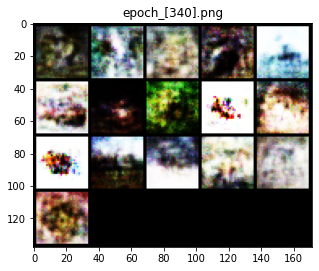

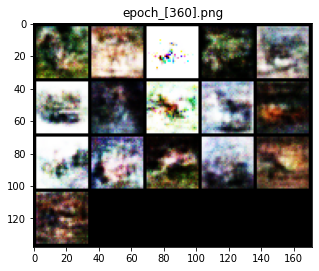

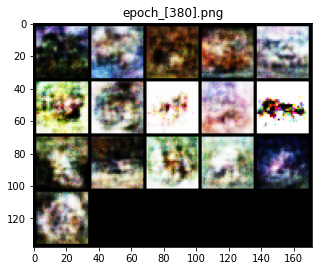

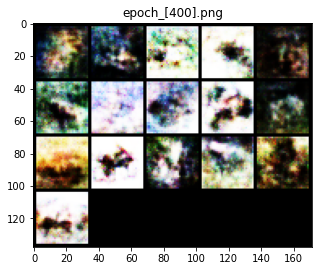

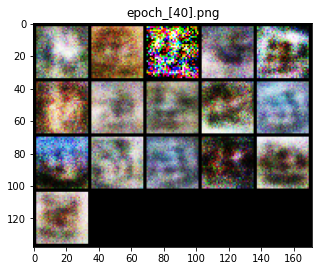

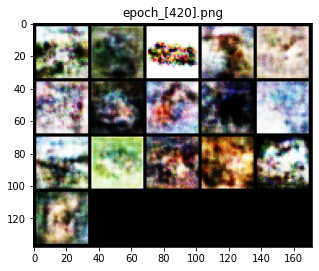

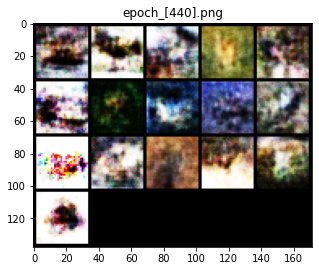

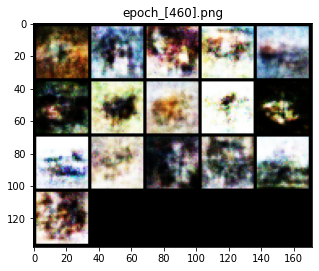

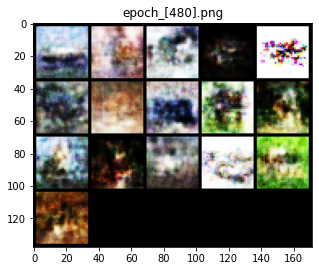

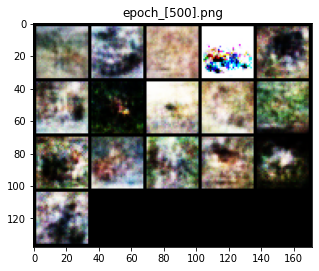

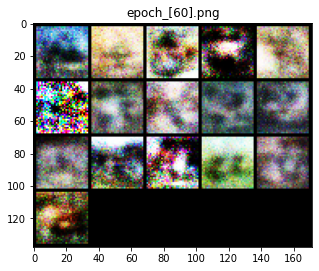

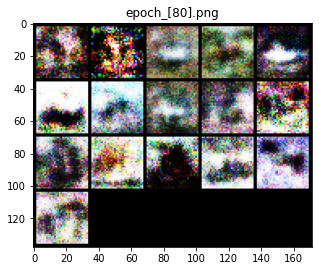

In [17]:
save_path = os.path.join(config.save_path, config.dataset)
for image_path in os.listdir(save_path):
    if image_path.endswith('.png'):
        plt.figure(figsize=(5,5))
        image = Image.open(os.path.join(save_path, image_path))
        plt.title(image_path)
        plt.imshow(image)
        plt.show()